<a href="https://colab.research.google.com/github/wangleiphy/ml4p/blob/main/materials/2_handson/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is reorganized from a chatgpt output. A few used prompts 

- please write for me an tutorial code of training a classifier using the MNIST data, the code should be written in Jax"


- please write latex formula of this code "-jnp.mean(jnp.sum(y * jax.nn.log_softmax(logits), axis=1))"


- replace this "[(w - learning_rate * dw, b - learning_rate * db) for (w, b), (dw, db) in zip(params, grads)]" with a tree_map




In [3]:
!nvidia-smi

Fri Feb 24 13:38:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Data

First, let's get the MNIST data and prepare them into suitible format

In [5]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Flatten images into a vector
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

# Normalize pixel values
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# One-hot encode labels
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11490434/11490434 [==============================] - 0s 0us/step


In [9]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

Let's have a look at the first few images

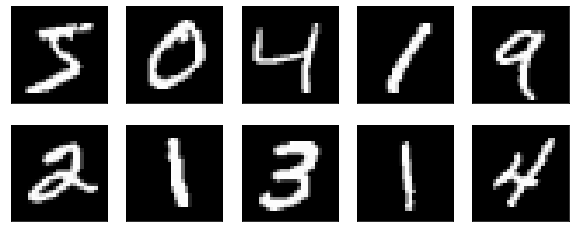

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i].reshape(28, 28), cmap='gray')
plt.show()

and their labels

In [15]:
print (y_train[:10]) 

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


# Model

In [31]:
def make_network(layer_sizes):
    def init(key, scale=1e-2):
        params = []
        for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:]):
            weight_key, bias_key = jax.random.split(key)
            weight = scale * jax.random.normal(weight_key, (n_in, n_out))
            bias = scale * jax.random.normal(bias_key, (n_out,))
            params.append((weight, bias))
        return params

    def relu(x):
        return jnp.maximum(0, x)

    def apply(params, x):
        for w, b in params[:-1]:
            x = relu(jnp.dot(x, w) + b)
        final_w, final_b = params[-1]
        return jnp.dot(x, final_w) + final_b

    return init, apply

We can not initialize the neural network

In [33]:
layer_sizes = [784, 128, 64, 10] # IN: 784 pixels, OUT: 10 classes
init_fn, apply_fn = make_network(layer_sizes)
key = jax.random.PRNGKey(42)
params = init_fn(key)

# Loss

The loss function reads $$\mathcal{L} =- \frac{1}{n} \sum_{i=1}^{n} \sum_{j=1}^{m} y_{i,j} \log \left( \frac{\exp(logits_{i,j})}{\sum_{k=1}^{m} \exp(logits_{i,k})} \right)$$

Here, $n$ is the number of samples in the batch, $m$ is the number of classes, $y_{i,j}$ is the one-hot encoded target label for sample $i$ and class $j$, $logits_{i,j}$ is the logit (i.e., the output of the linear transformation before applying the softmax activation) for sample $i$ and class $j$, and logsoftmax denotes the log of the softmax function applied element-wise to the logits.

The expression inside the summation is the cross-entropy loss between the predicted probabilities (obtained by applying the softmax function to the logits) and the true one-hot encoded labels. The outer summation and mean are taken over the batch of samples to obtain the average loss per sample.

In [41]:
def cross_entropy_loss(params, x, y):
    logits = apply_fn(params, x)
    return -jnp.mean(jnp.sum(y * jax.nn.log_softmax(logits), axis=1))

# Optimization

In [48]:
# Define the update function
@jax.jit
def update(params, x, y, learning_rate):
    grads = jax.grad(cross_entropy_loss)(params, x, y)
    return jax.tree_map(lambda p, g: p - learning_rate * g, params, grads)

# Define the accuracy function
def accuracy(params, x, y):
    predictions = jnp.argmax(apply_fn(params, x), axis=1)
    actual = jnp.argmax(y, axis=1)
    return jnp.mean(predictions == actual)

In [75]:
learning_rate = 0.1
num_epochs = 10
batch_size = 128

train_size = x_train.shape[0]
num_complete_batches, leftover = divmod(train_size, batch_size)
num_batches = num_complete_batches + bool(leftover)

for epoch in range(num_epochs):
    # Shuffle the training data
    key, subkey = jax.random.split(key)
    permutation = jax.random.permutation(subkey, train_size)
    x_train = x_train[permutation]
    y_train = y_train[permutation]

    for i in range(num_batches):
        # Get batch data
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        x_batch = x_train[batch_start:batch_end]
        y_batch = y_train[batch_start:batch_end]

        # Update parameters
        params = update(params, x_batch, y_batch, learning_rate)

    # Compute accuracy on training and test sets
    train_accuracy = accuracy(params, x_train, y_train)
    test_accuracy = accuracy(params, x_test, y_test)
    print(f"Epoch {epoch}: train accuracy = {train_accuracy:.3f}, test accuracy = {test_accuracy:.3f}")

Epoch 0: train accuracy = 0.999, test accuracy = 0.978
Epoch 1: train accuracy = 0.999, test accuracy = 0.979
Epoch 2: train accuracy = 0.999, test accuracy = 0.979
Epoch 3: train accuracy = 1.000, test accuracy = 0.979
Epoch 4: train accuracy = 0.999, test accuracy = 0.978
Epoch 5: train accuracy = 0.999, test accuracy = 0.977
Epoch 6: train accuracy = 1.000, test accuracy = 0.979
Epoch 7: train accuracy = 1.000, test accuracy = 0.979
Epoch 8: train accuracy = 1.000, test accuracy = 0.979
Epoch 9: train accuracy = 1.000, test accuracy = 0.979


Let's see it for real for the first 10 test cases

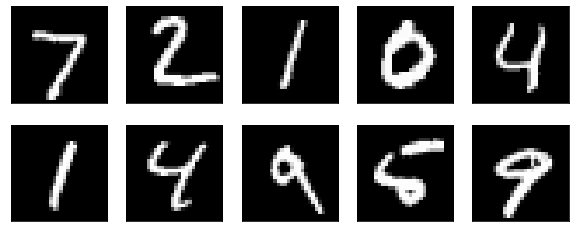

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i].reshape(28, 28), cmap='gray')
plt.show()

In [52]:
jnp.argmax(apply_fn(params, x_test[:10]), axis=1)

DeviceArray([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int32)

Let's look at some case where the model made wrong prediction

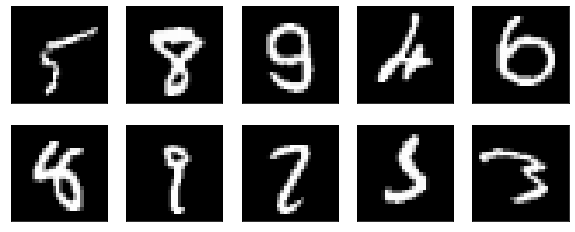

In [72]:
predictions = jnp.argmax(apply_fn(params, x_test), axis=1)
actual = jnp.argmax(y_test, axis=1)
idx = jnp.where(predictions != actual)[0]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[idx[i]].reshape(28, 28), cmap='gray')
plt.show()

In [71]:
jnp.argmax(apply_fn(params, x_test[idx[:10], :]), axis=1)

DeviceArray([7, 7, 5, 2, 0, 4, 7, 7, 3, 7], dtype=int32)